#### Code to train models

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
cd ../src

/home/theo/kaggle/siim_covid/src


## Imports

In [5]:
import os
import cv2
import glob
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm
from matplotlib.patches import Rectangle

In [6]:
from params import *

In [7]:
from data.preparation import prepare_dataframe, handle_duplicates, add_additional_boxes
from data.dataset import CovidDetDataset, CovidClsDataset
from data.transforms import get_transfos_det, get_transfos_cls

from model_zoo.models import get_model
from model_zoo.encoders import get_encoder

from utils.plot import plot_sample
from utils.boxes import treat_boxes
from utils.logger import prepare_log_folder, save_config, create_logger, update_overall_logs

from training.main import k_fold

## Datasets

#### CXR

In [6]:
CXR_PATH = "../input/lungs/cxr_dataset/"

0it [00:00, ?it/s]

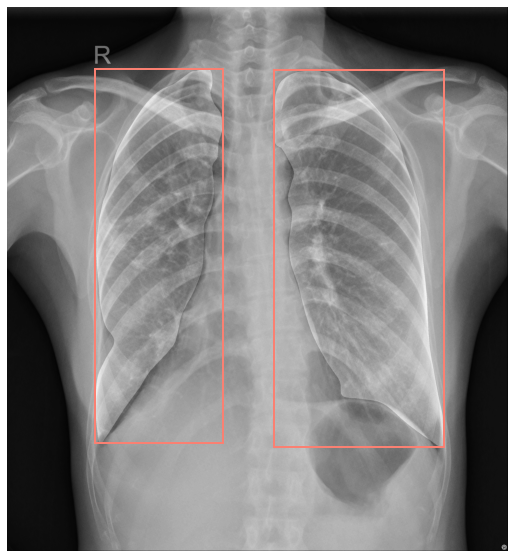

In [16]:
imgs = glob.glob(CXR_PATH + "*/*.png")
boxes_dic_cxr = {}

for i, img_path in tqdm(enumerate(imgs)):
    base, img_name = img_path.split('/')[-2:]
    
    mask_path = CXR_PATH + "mask/" + base + "/" + img_name
    
    if not os.path.exists(mask_path):
        continue
    
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    
    n_components, comps, boxes, _ = cv2.connectedComponentsWithStats(mask[:, :, 0])
    
    boxes = np.array(boxes)[1:]
    boxes = boxes[boxes[:, 2] > 100]
    boxes = boxes[boxes[:, 3] > 100]

    if len(boxes) != 2:
        continue
        print(boxes)
#         continue
    
    if not i % 100:
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.imshow(mask, alpha=0.2)
    
        for box in boxes:
    #         print(box)
            rect = Rectangle(
                (box[0], box[1]), box[2], box[3],
                linewidth=2, edgecolor='salmon', facecolor='none'
            )
            plt.gca().add_patch(rect)
        plt.axis(False)
        plt.show()

    boxes_dic_cxr[img_path] = boxes.astype(int).tolist()

with open('../output/boxes_cxr.json', 'w') as f:
    json.dump(boxes_dic_cxr, f)

#### Siim-covid

In [8]:
SIIM_PATH = "../input/lungs/siim/"

In [9]:
df = pd.concat([
    pd.read_csv('../input/df_train_512.csv'),
    pd.read_csv('../input/df_test_512.csv'),
])

In [14]:
img_path.split('/')[-1]

'bc641c321681_5caf07ed75f4.png'

In [15]:
df['save_name']

0       5776db0cec75_000a312787f2.png
0       795051254905_557a70442928.png
1       0d476d070d71_36141cda67ad.png
2       4996bf5117c7_2413a23a5477.png
3       8b273337a684_c263b1e9aa64.png
                    ...              
1258    ee860264dd8c_46719b856de1.png
1259    81c860c6efe8_31c07523a69a.png
1260    e6e02ec8aff5_f77d7d1aebab.png
1261    b93bfa119338_ccc5b63ca96d.png
1262    b93bfa119338_5e8ac1fe2b82.png
Name: save_name, Length: 1264, dtype: object

In [13]:
df[df['save_name'] == img_path.split('/')[-1]]

,study_id,series_id,image_id,save_name,shape,shape_crop,window,crop_starts,photometric_interpreation,series_number,instance_number


In [10]:
imgs = glob.glob(SIIM_PATH + "images/*/*.jpg")
imgs_proc = glob.glob(DATA_PATH + "train_512/*") + glob.glob(DATA_PATH + "test_512/*")
boxes_dic_siim = {}

for i, img_path in tqdm(enumerate(imgs)):
    base, img_name = img_path.split('/')[-2:]
    
    img_path = [f for f in imgs_proc if img_name.split('.')[0] in f][0]
    
    crops, orig_shape, orig_shape_crop = df[df['save_name'] == img_path.split('/')[-1]][
        ['crop_starts', 'shape', 'shape_crop']
    ].values[0]
    crops = np.array(crops[1:-1].split(', ')).astype(int)
    orig_shape = np.array(orig_shape[1:-1].split(', ')).astype(int)
    orig_shape_crop = np.array(orig_shape_crop[1:-1].split(', ')).astype(int)

    img = cv2.imread(img_path)

    box_path = SIIM_PATH + "labels/" + base + "/" + img_name.split('.')[0] + ".txt"

    if not os.path.exists(box_path):
        print(box_path)
#         continue

    boxes = open(box_path, 'r').readlines()
    boxes = np.array([np.array(b[:-1].split(' ')).astype(float) for b in boxes])
    boxes = boxes[boxes[:, 0] < 2][:, 1:]

    h, w, _ = img.shape

#     orig_shape_crop =  orig_shape - crops * 1.5
    
    if crops.max():
        boxes[:, [2, 0]] *= orig_shape[1]
        boxes[:, [3, 1]] *= orig_shape[0]

        boxes[:, 0] -= crops[1]
        boxes[:, 1] -= crops[0]

        boxes[:, [2, 0]] /= orig_shape_crop[1]
        boxes[:, [3, 1]] /= orig_shape_crop[0]
    
    
    if crops.max() > 300:
        print(orig_shape, crops)
        print(orig_shape_crop[1] / orig_shape[1], orig_shape_crop[0] / orig_shape[0])
        
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        for box in boxes:
            
            rect = Rectangle(
                ((box[0] - box[2] / 2) * w, (box[1] - box[3] / 2) * h), box[2] * w, box[3] * h,
                linewidth=2, edgecolor='salmon', facecolor='none'
            )
            plt.gca().add_patch(rect)
        plt.axis(False)
        plt.show()        
        break    
    boxes_dic_siim[img_path] = boxes
    
with open('../output/boxes_siim.json', 'w') as f:
    json.dump(boxes_dic_siim, f)

0it [00:00, ?it/s]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [20]:
with open('../output/boxes_siim.json', 'w') as f:
    json.dump(boxes_dic_siim, f)